# Lending Strategy - Real bank data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV,KFold
from sklearn.metrics import roc_curve, auc,accuracy_score

In [44]:
#unzip data into current directory 
!tar -xf data.zip

In [2]:
# Read data to pandas dataframes
df_loans = pd.read_csv('data/loan_table.csv')
df_borw = pd.read_csv('data/borrower_table.csv')

In [3]:
# Scoring function- scores any strategy according to the given scoring table
def get_score(df,decision_vector):
    score_vector = np.where(df[f'{decision_vector}']==0,0, 2*df['loan_repaid'] -1)
    return sum(score_vector)

# Data Exploration & Preprocessing

In [4]:
df_loans.head(3)

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN


In [5]:
df_borw.head(3)

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8


In [6]:
# check the data dypes in both dataframes
print(df_loans.dtypes)
print('---------------------------------------------------')
print(df_borw.dtypes)

loan_id           int64
loan_purpose     object
date             object
loan_granted      int64
loan_repaid     float64
dtype: object
---------------------------------------------------
loan_id                                              int64
is_first_loan                                        int64
fully_repaid_previous_loans                        float64
currently_repaying_other_loans                     float64
total_credit_card_limit                              int64
avg_percentage_credit_card_limit_used_last_year    float64
saving_amount                                        int64
checking_amount                                      int64
is_employed                                          int64
yearly_salary                                        int64
age                                                  int64
dependent_number                                     int64
dtype: object


In [7]:
# The 'loan purpose' colomn type is string. We should perform one-hot encoding 
one_hot = pd.get_dummies(df_loans['loan_purpose'])
df_loans = df_loans.join(one_hot.add_suffix('_one_hot'))
df_loans = df_loans.drop(columns=['loan_purpose'])

In [8]:
# Extract the month from the 'loan date' (this might take ~20 seconds to run)
dates = []
for idx, row in df_loans.iterrows():
    date = df_loans.loc[idx]['date'] 
    dates.append(datetime.strptime(date,'%Y-%m-%d').month)
df_loans['loan_month'] = dates
# drop the oriinal date column
df_loans = df_loans.drop(columns=['date'])

In [9]:
#checking if the load id's are unique in both data sets 
print(df_loans.shape[0])
print(len(set(df_loans.loan_id)))
print(df_loans.shape[0])
print(len(set(df_borw.loan_id)))
# id's are unique 

101100
101100
101100
101100


In [10]:
# merge the loan and borrowers data sets
df_mrg = pd.merge(left=df_loans,right=df_borw,on='loan_id')

## We want to see how the numeric features distribute and if there are outliers that we should handle

In [11]:
df_mrg.columns

Index(['loan_id', 'loan_granted', 'loan_repaid', 'business_one_hot',
       'emergency_funds_one_hot', 'home_one_hot', 'investment_one_hot',
       'other_one_hot', 'loan_month', 'is_first_loan',
       'fully_repaid_previous_loans', 'currently_repaying_other_loans',
       'total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'is_employed', 'yearly_salary', 'age',
       'dependent_number'],
      dtype='object')

c:\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


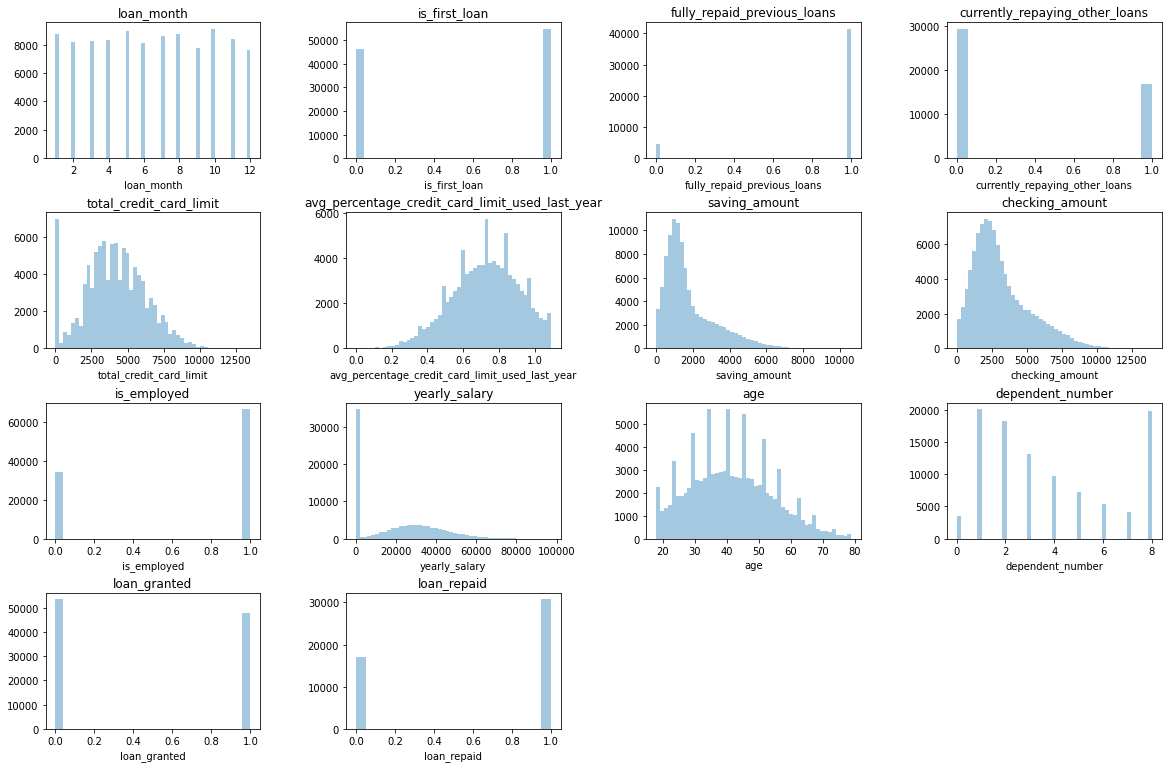

In [12]:
# Distribution plots
features_to_check = list(df_mrg.iloc[:,8:].columns ) + ['loan_granted', 'loan_repaid']
fig = plt.figure(figsize=(20,13))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plot_num=1
for feature in features_to_check:
    ax = fig.add_subplot(4,4,plot_num)
    plot_num+=1
    sns.distplot(df_mrg.loc[:,feature],kde=False)
    ax.set(title = feature)

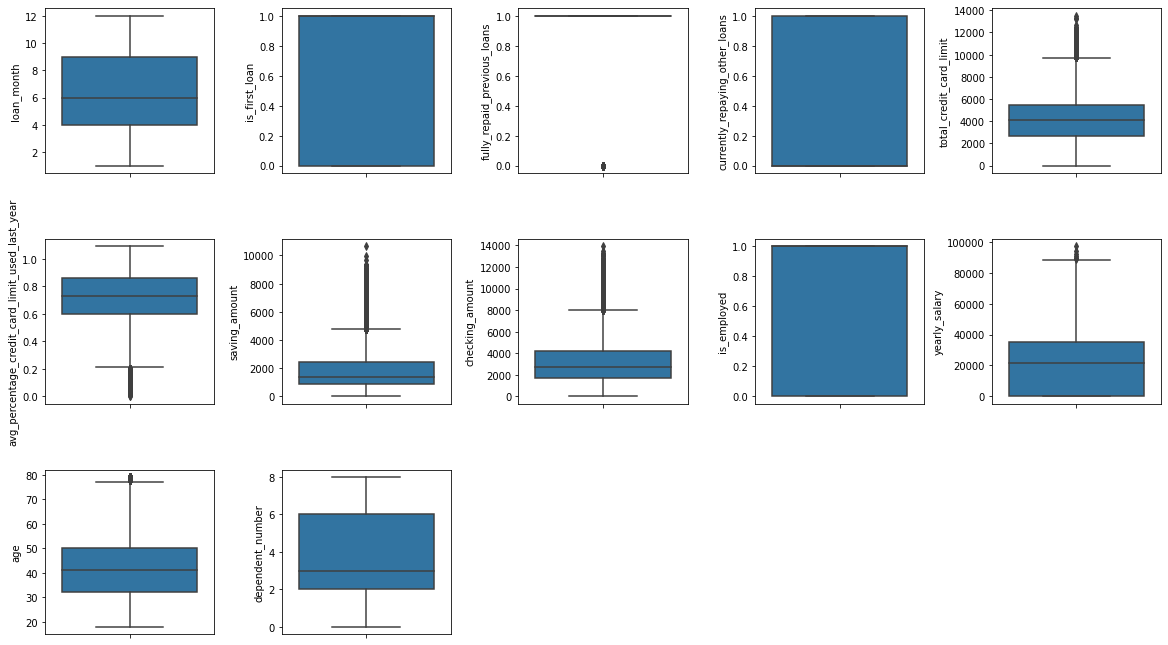

In [13]:
#  Boxplots
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plot_num=1
for feature in df_mrg.iloc[:,8:].columns:
    ax = fig.add_subplot(5,5,plot_num)
    plot_num+=1
    sns.boxplot(y= df_mrg.loc[:,feature],orient='v')

**Let's take a look on the distribution of loan repaid agg by the loan month & the distribution of loan granted agg by loan month**

<AxesSubplot:xlabel='loan_month', ylabel='loan_repaid'>

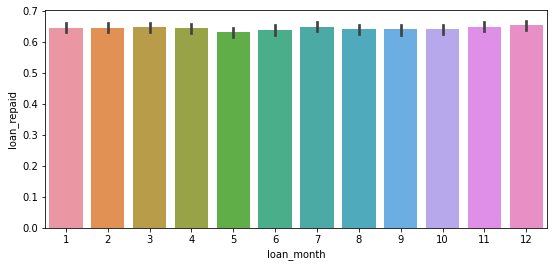

In [14]:
df_grouped_month = df_mrg.groupby('loan_month')['loan_repaid'].mean().reset_index()
plt.rcParams["figure.figsize"] = [9,4]
sns.barplot(x = 'loan_month',y='loan_repaid', data=df_mrg)

<AxesSubplot:xlabel='loan_month', ylabel='loan_granted'>

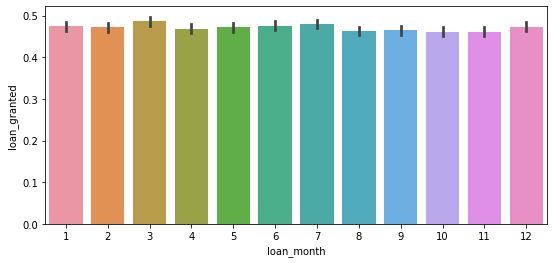

In [15]:
df_grouped_month = df_mrg.groupby('loan_month')['loan_granted'].mean().reset_index()
plt.rcParams["figure.figsize"] = [9,4]
sns.barplot(x = 'loan_month',y='loan_granted', data=df_mrg)

*From those two figures we understand that the feature 'loan month' doesn't really contribute a lot.*
**we can get rid of it**

In [16]:
df_mrg = df_mrg.drop(columns='loan_month')

In [17]:
# we shall take another look at the dependent variables distribution
print(df_mrg.loan_granted.value_counts(normalize=True))
print('-------------------------------------------------')
print(df_mrg.loan_repaid.value_counts(normalize=True))

0    0.528645
1    0.471355
Name: loan_granted, dtype: float64
-------------------------------------------------
1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64


## ***we can understand that more than half of the loan applications are not even approved**

In [18]:
# we shall look for null values 
df_mrg.isnull().sum() / df_mrg.shape[0]

loan_id                                            0.000000
loan_granted                                       0.000000
loan_repaid                                        0.528645
business_one_hot                                   0.000000
emergency_funds_one_hot                            0.000000
home_one_hot                                       0.000000
investment_one_hot                                 0.000000
other_one_hot                                      0.000000
is_first_loan                                      0.000000
fully_repaid_previous_loans                        0.543492
currently_repaying_other_loans                     0.543492
total_credit_card_limit                            0.000000
avg_percentage_credit_card_limit_used_last_year    0.068961
saving_amount                                      0.000000
checking_amount                                    0.000000
is_employed                                        0.000000
yearly_salary                           

## A correlation map can give us a better sense of the features relations

c:\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

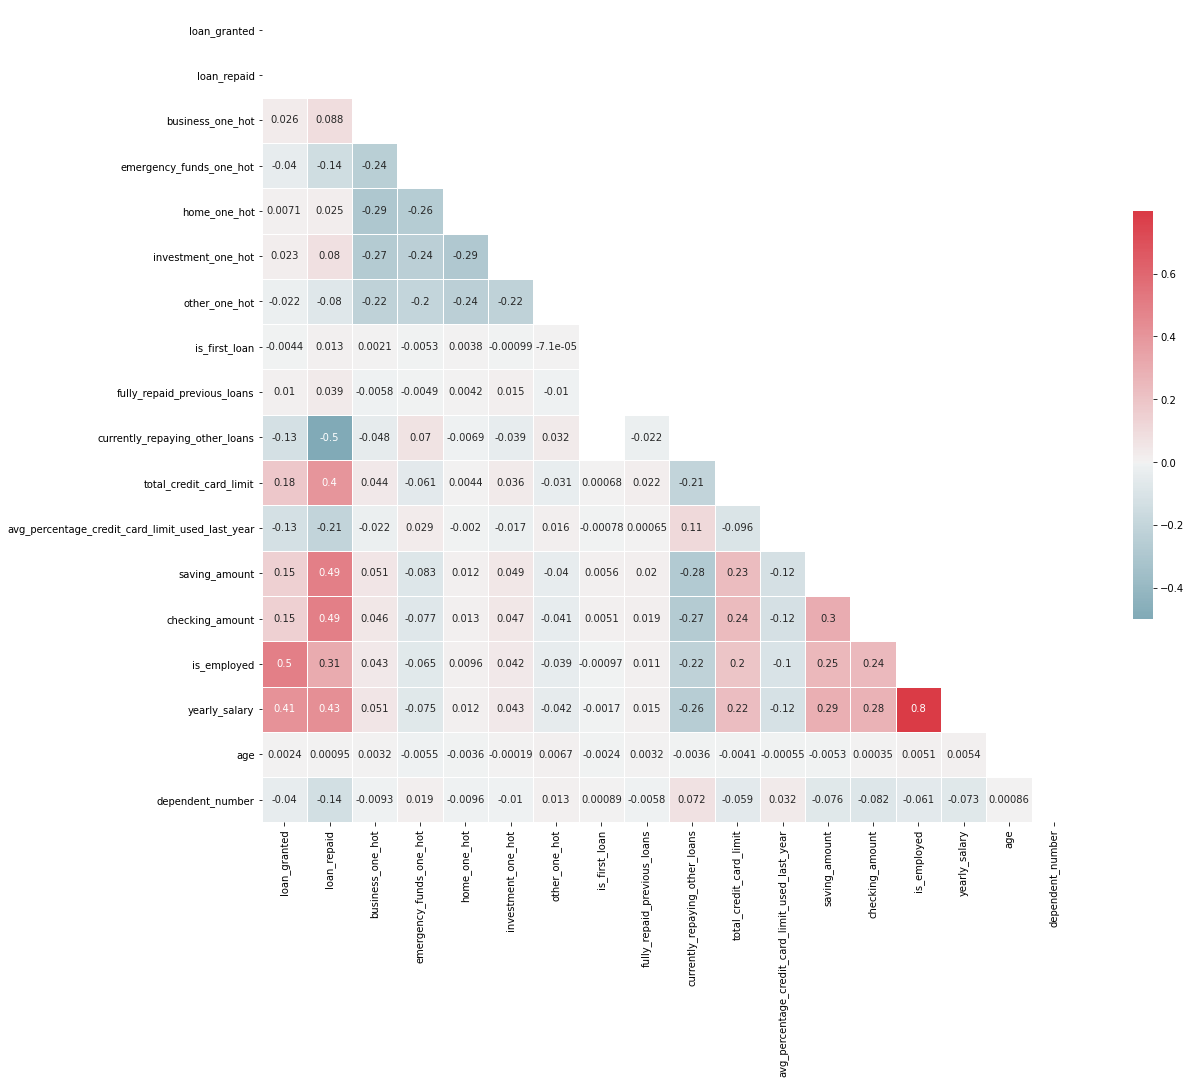

In [19]:
corr = df_mrg.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot=True,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
# Create a filtedred dataset only for cases where the loan was granted by the bank
df_mrg_aprv = df_mrg[df_mrg.loan_granted==1].copy()

In [21]:
df_mrg_aprv.loan_repaid.value_counts(normalize=True)

1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64

# PCA - Visualizing the data in a lower dimension space
Before fitting a classifer to the data that will optimize the potential score, we can check if there's a distict seperetion between clients that repay the loans vs those who dont pay, and clients who get the loan and those who get rejected. 
We can reduct the 16 dimension feature space to 2 components that hold most of the information using PCA.
Those components are a linear combination of all features 

## PCA figure 1- seperation of clients who repaid/didn't reapy the loan *out of clients that recieved the loan

Text(0, 0.5, 'Second principle component')

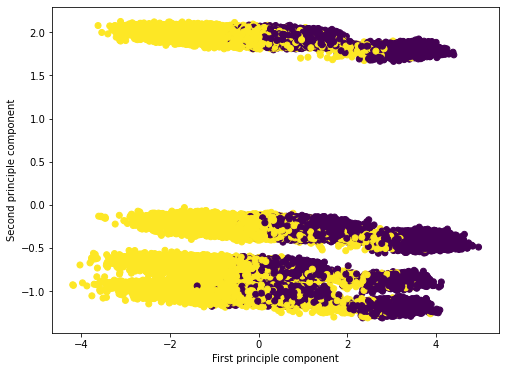

In [22]:
# scale our data first
scaler=StandardScaler()
df_pca = df_mrg_aprv.iloc[:,2:].dropna(axis='columns')
X = df_pca.iloc[:,1:] #features
#perform scaling prior to pca transformation
scaler.fit(X)
scaled_data=scaler.transform(X)
#fit pca onthe scaled data
pca=PCA(n_components=2)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)
# 2d plot of the components
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df_pca['loan_repaid']) 
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

## PCA figure 2 - seperation of cliented whose loans' applications were approved/didn't approved *out of all clients

Text(0, 0.5, 'Second principle component')

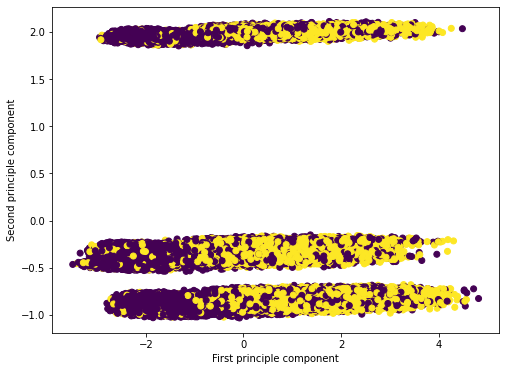

In [23]:
# scale our data first
scaler=StandardScaler()
df_pca_2 = df_mrg.drop(columns=['loan_repaid','loan_id']).dropna(axis='columns')
X_2 = df_pca_2.iloc[:,1:]
scaler.fit(X_2)
scaled_data=scaler.transform(X_2)
#fir pca
pca=PCA(n_components=2)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)
# 2d plot of the components
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=df_pca_2['loan_granted'])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

## we can understand many things about the data from those two figures:
1. The seperation in PCA figure 1 is much more clear - **we can almost 'draw' a decision boundary without fitting any algorithm**. we can see how to features 'tell us' the difference between people that repay the loan and those who don't.
2. Figure 2 is very messy with no clear decision bountry ***This can imply us that the bank's strategy is not ideal**.

# Model and Scoring

In [24]:
# the column 'loan granted' shows us the bank's decision about each applicant
bank_score = get_score(df_mrg,'loan_granted')
print(f'***The bank score is {bank_score}***')

***The bank score is 13758.0***


# XGBoost model

In [25]:
df_mrg_aprv = df_mrg[df_mrg.loan_granted==1].copy()

In [26]:
X = df_mrg_aprv.drop(columns=['loan_id','loan_repaid','loan_granted']).copy()
y = df_mrg_aprv['loan_repaid']

we want to split the data to train and test sets. we use *stratified split* in order to preserve the class distribution in the split*

In [27]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [34333 12667 26806 ... 31555 46542 29439] TEST: [40796  3503 18558 ... 26526 31517 18639]
TRAIN: [ 7781 44374  4455 ...  4364 19548 44465] TEST: [26445 20460  2074 ... 36035 42383 23156]


In [28]:
# ** This hyper-parameter search might some time to run (~ 4 minutes)

*To optimize the hyper parameters, we will run grid search cross validation with roc-auc as scoring function*.
we can use all different folds of the data as validation set every time so that we woll not 'waste' date.

In [29]:
parameter_options = {'n_estimators' : [20,25,30],
                    'max_depth': [5,10,20],
                    'max_delta_step ': [0.01,0.05,0.01]}
xgb_clf = GridSearchCV(XGBClassifier(max_iter=1000,use_label_encoder=False,verbosity=0), parameter_options,cv=5, scoring= 'roc_auc')
xgb_clf.fit(X_train,y_train)
print(xgb_clf.best_params_)
print(xgb_clf.best_score_)

{'max_delta_step ': 0.01, 'max_depth': 5, 'n_estimators': 30}
0.976189625660199


In [30]:
def KfoldPlot(X, y, clf, k):
    kf = KFold(n_splits=k)
    mean_fpr= np.linspace(0, 1, 200) 
    mean_tpr=0
    mean_thresholds=[]
    for train_index, test_index in kf.split(X): 
        X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
        y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
        clf.fit(X= X_train, y= y_train) 
        y_score = clf.predict_proba(X_test)[:,1] 
        fpr, tpr, thresholds =roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, 'g') 
        mean_tpr += np.interp(mean_fpr, fpr, tpr) 
    mean_tpr /= k    
    mean_tpr[0]=0
    mean_tpr[-1]=1
    mean_auc = '%.3f'% auc(mean_fpr, mean_tpr) 
    plt.plot([0], [0], color='g', label='K-folds') 
    plt.plot(mean_fpr ,mean_tpr, "r", label = "Mean ROC (area = {})".format(mean_auc))
    plt.plot([0,1],[0,1], ls= "--")
    plt.xlabel("False Positive Rate") 
    plt.ylabel("True Positive Rate")
    plt.title("ROC for "+ str(clf)[:str(clf).find("(")])
    plt.legend(loc="lower right")
    plt.show()

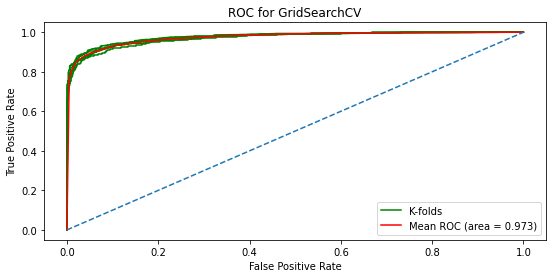

In [31]:
KfoldPlot(X_train,y_train,xgb_clf,5)

**We get a very good mean ROC score!**

In [32]:
xgb_clf_best = XGBClassifier(max_iter=1000,max_delta_step= 0.05, max_depth= 5, n_estimators= 15,verbosity=0)
xgb_clf_best.fit(X_train,y_train)

c:\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0.05, max_depth=5,
              max_iter=1000, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=15, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0)

 **Now, we should test our algorithm on unseen data (the test set)**

In [33]:
y_pred = xgb_clf_best.predict(X_test)
xgb_accuracy = accuracy_score(y_test,y_pred)
xgb_accuracy

0.882908404154863

**We get accuracy of more than 88%**

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

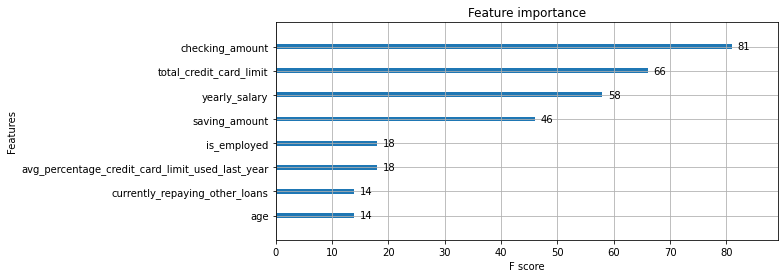

In [34]:
# feature importance 
xgb_clf_best.get_booster().feature_names = list(X.columns)
plot_importance(xgb_clf_best)

In [35]:
df_mrg_aprv['xgb_best_granted'] = xgb_clf_best.predict(df_mrg_aprv.drop(columns=['loan_id','loan_repaid','loan_granted']))

In [36]:
score_with_bank_rejects = get_score(df_mrg_aprv,'xgb_best_granted')
print(f"""score with our model and the bank's rejects is {score_with_bank_rejects}""")

score with our model and the bank's rejects is 25226.0


**Now, let's check our strategy on all the data - including applicant whose loan applications were declined**

In [37]:
df_mrg['xgb_best_granted_all'] = xgb_clf_best.predict(df_mrg.drop(columns=['loan_id','loan_repaid','loan_granted']))
should_apr_xgb = df_mrg[(df_mrg.loan_granted==0) & (df_mrg.xgb_best_granted_all==1)].shape[0]
print(f'number of cases that our model would grant a loan where the bank did not : {should_apr_xgb}')

number of cases that our model would grant a loan where the bank did not : 21769


**Let check the number of cases that our model determines to give a loan and the bank's model advises not to**

In [38]:
print(f"""precentage of cases that could have been approved out of all the bank's rejects {100*should_apr_xgb/df_mrg[df_mrg.loan_granted==0].shape[0]}%""")

precentage of cases that could have been approved out of all the bank's rejects 40.730831119260564%


**Expected Extra profit with this strategy**

Given the fact that our model is wrong ~11% of the cases

In [39]:
extra_potential_prof = xgb_accuracy*should_apr_xgb - (1-xgb_accuracy)*should_apr_xgb 
print(f'The extra potential profit with our model is {extra_potential_prof}')
print(f'Total profit- actual + poential is : {score_with_bank_rejects + extra_potential_prof}')

The extra potential profit with our model is 16671.066100094424
Total profit- actual + poential is : 41897.066100094424


**we see that with this approach we could approved 40% out of the bank's rejects could result in a profit of almost 41900**

In [40]:
# cases where both our model and the bank's decided to reject
df_mrg[(df_mrg.loan_granted==0) & (df_mrg.xgb_best_granted_all==0)].shape[0]

31677

# Notes
1. With a more extensive hyper-parameters search we could find better results but we're limited with the time.
2. In this model, We ignored the bank strategy and trained the model on cases where that loan was granted by the bank.